In [143]:
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten
from jax import random, grad, jit, vmap, nn
from jax.scipy.special import logsumexp
import random as r
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocab mapping from char to int and vice versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words[:5]:
    print(w)

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = jnp.array(X)
Y = jnp.array(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, Y.shape, X.dtype, Y.dtype

((32, 3), (32,), dtype('int32'), dtype('int32'))

In [9]:
key = random.PRNGKey(10)
C = random.normal(key, (27, 2))

In [10]:
C[5]

Array([0.7563773, 1.440487 ], dtype=float32)

In [11]:
nn.one_hot(x=jnp.array(5), num_classes=27, dtype=jnp.float32) @ C

Array([0.7563773, 1.440487 ], dtype=float32)

In [12]:
C[X]

Array([[[ 0.3976291 , -0.92553115],
        [ 0.3976291 , -0.92553115],
        [ 0.3976291 , -0.92553115]],

       [[ 0.3976291 , -0.92553115],
        [ 0.3976291 , -0.92553115],
        [ 0.7563773 ,  1.440487  ]],

       [[ 0.3976291 , -0.92553115],
        [ 0.7563773 ,  1.440487  ],
        [-1.1102754 ,  0.42526308]],

       [[ 0.7563773 ,  1.440487  ],
        [-1.1102754 ,  0.42526308],
        [-1.1102754 ,  0.42526308]],

       [[-1.1102754 ,  0.42526308],
        [-1.1102754 ,  0.42526308],
        [-0.8551027 , -1.1744124 ]],

       [[ 0.3976291 , -0.92553115],
        [ 0.3976291 , -0.92553115],
        [ 0.3976291 , -0.92553115]],

       [[ 0.3976291 , -0.92553115],
        [ 0.3976291 , -0.92553115],
        [-1.8809125 ,  0.4962055 ]],

       [[ 0.3976291 , -0.92553115],
        [-1.8809125 ,  0.4962055 ],
        [-1.4253994 ,  1.8203468 ]],

       [[-1.8809125 ,  0.4962055 ],
        [-1.4253994 ,  1.8203468 ],
        [ 0.20761481,  0.4950672 ]],

       [[-

In [16]:
W1 = random.normal(key, (6, 100))
b1 = random.normal(key, (100, ))

In [27]:
emb = C[X]
print(f'{C.shape=}')
print(f'{X.shape=}')
print(f'{emb.shape=}')

C.shape=(27, 2)
X.shape=(32, 3)
emb.shape=(32, 3, 2)


In [38]:
emb_nn = jnp.reshape(emb, (-1, emb.shape[1] * emb.shape[2]))
emb_nn.shape

(32, 6)

In [36]:
emb_nn_alt = jnp.concat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], axis=1)
emb_nn_alt.shape

(32, 6)

In [39]:
h = emb_nn @ W1 + b1
h.shape

(32, 100)

In [40]:
W2 = random.normal(key, (100, 27))
b2 = random.normal(key, (27, ))

In [41]:
logits = h @ W2 + b2
logits.shape

(32, 27)

In [42]:
counts = jnp.exp(logits)

In [45]:
probs = counts / jnp.sum(counts, 1, keepdims=True)
print(f'{probs.shape=}')

probs.shape=(32, 27)


In [82]:
# MAKE CODE CLEANER ------------------------------

In [242]:
# Setup:
BLOCK_SIZE = 3 # context length: how many characters do we take to predict the next one?
VOCAB_SIZE = 27
NUM_FEATURES = 10
IN_SIZE = BLOCK_SIZE * NUM_FEATURES
L1_SIZE = 200
OUT_SIZE = VOCAB_SIZE


In [243]:
# build the dataset

def create_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * BLOCK_SIZE

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = jnp.array(X)
    Y = jnp.array(Y)
    return X, Y

# build a dataset of 80% train, 10% validation, and 10% test sets.
def split_dataset(words):
    r.seed(42)
    r.shuffle(words)
    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))

    Xtr, Ytr = create_dataset(words[:n1])
    Xval, Yval = create_dataset(words[n1:n2])
    Xte, Yte = create_dataset(words[n2:])

    return Xtr, Ytr, Xval, Yval, Xte, Yte


In [244]:
X, Y = create_dataset(words)
X.shape, Y.shape

Xtr, Ytr, Xval, Yval, Xte, Yte = split_dataset(words)

In [245]:
C = random.normal(key, (VOCAB_SIZE, NUM_FEATURES))
W1 = random.normal(key, (IN_SIZE, L1_SIZE))
b1 = random.normal(key, (L1_SIZE, ))
W2 = random.normal(key, (L1_SIZE, OUT_SIZE))
b2 = random.normal(key, (OUT_SIZE, ))
parameters = [C, W1, b1, W2, b2]

In [246]:
params, _ = tree_flatten(parameters)
sum(jnp.size(p) for p in params)

11897

In [220]:
def predict(C, W1, b1, W2, b2, X):
    emb = C[X]
    h = jnp.tanh(jnp.reshape(emb, (-1, emb.shape[1] * emb.shape[2])) @ W1 + b1)
    logits = h @ W2 + b2
    return logits

@jit
def cross_entropy_loss(params, X, Y):
    logits = predict(*params, X)
    counts = jnp.exp(logits - logsumexp(logits, axis=1, keepdims=True)) # logits - logsumexp(logits) ensures that there aren't overflow errors
    probs = counts / jnp.sum(counts, 1, keepdims=True)
    def get_idx(prob, y):
        return -jnp.log(prob[y])
    vectorized_probs = vmap(get_idx)(probs, Y)
    return vectorized_probs.mean()
    

In [221]:
@jit
def update(parameters, X, Y, lr=0.1):
    grads = grad(cross_entropy_loss)(parameters, X, Y)
    return [ p - lr * g for p, g in zip(parameters, grads) ]


In [247]:
# For learning rate optimization
lre = jnp.linspace(-3, 0, 1000)
lrs = 10**lre
lossi = []
stepi = []

In [249]:
def train(parameters, X, Y, key, lr=0.1, epochs=10):
    for i in range(epochs):
        key, _ = random.split(key)
        ix = random.randint(key, (32, ), 0, X.shape[0]) # create random batch indicies

        # lr = lrs[i]
        parameters = update(parameters, X[ix], Y[ix], lr)
        lossi.append(jnp.log10(cross_entropy_loss(parameters, X[ix], Y[ix])).item())
        stepi.append(i)
    return parameters

In [255]:
parameters = train(parameters, Xtr, Ytr, key, 0.01, 50000)
print(f"training loss: {cross_entropy_loss(parameters, Xtr, Ytr)}")
print(f"validation loss: {cross_entropy_loss(parameters, Xval, Yval)}")


training loss: 2.1549744606018066
validation loss: 2.1952459812164307


In [268]:
import torch
g = torch.Generator().manual_seed(2147483647)

def sample(parameters, num_words=5):
    for i in range(num_words):
        out = []
        context = [0] * BLOCK_SIZE # Initialize to ... (all state tokens)
        while True:
            logits = predict(*parameters, jnp.array(context).reshape(1, -1))
            probs = nn.softmax(logits, axis=1)

            ix = torch.multinomial(torch.tensor(probs.tolist()), num_samples=1, replacement=True, generator=g).item()
            context = context[1:] + [ix]
            out.append(itos[ix])
            if ix == 0:
                break

        print(''.join(out))

In [269]:
sample(parameters, 20)

cer.
marial.
makion.
kayda.
kalistanainella.
kamania.
samiyah.
jaleigh.
tai.
molie.
cayo.
keithia.
kaley.
maside.
eniaverry.
folst.
hunavendorrensu.
jade.
breenley.
alaira.


In [271]:

def functional_sample(parameters, num_words=5):
    def gen(context):
        logits = predict(*parameters, jnp.array(context).reshape(1, -1))
        probs = nn.softmax(logits, axis=1)

        ix = torch.multinomial(torch.tensor(probs.tolist()), num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        return context
    
    for i in range(num_words):
        def red(acc, context):
            ix = context[-1]
            if ix == 0:
                return acc + [itos[ix]]
            else:
                return red(acc + [itos[ix]], gen(context))
        out = red([], gen([0] * BLOCK_SIZE))
        print(''.join(out))

In [272]:
g = torch.Generator().manual_seed(2147483647)
functional_sample(parameters, 20)

cer.
marial.
makion.
kayda.
kalistanainella.
kamania.
samiyah.
jaleigh.
tai.
molie.
cayo.
keithia.
kaley.
maside.
eniaverry.
folst.
hunavendorrensu.
jade.
breenley.
alaira.


In [256]:
# Extra plots from various scattered experiments --------------------------

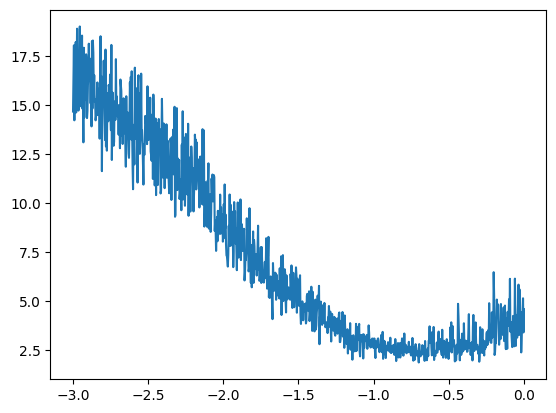

In [127]:
plt.plot(lre, lossi)

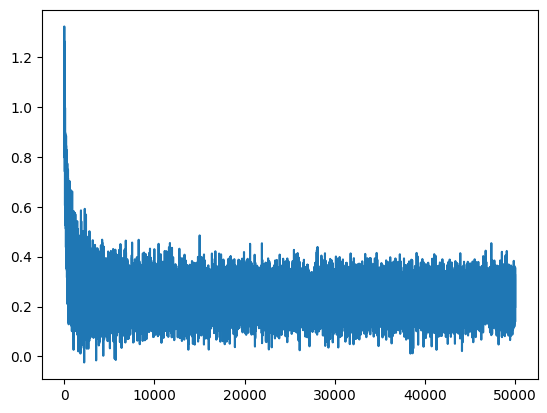

In [251]:
plt.plot(stepi, lossi)

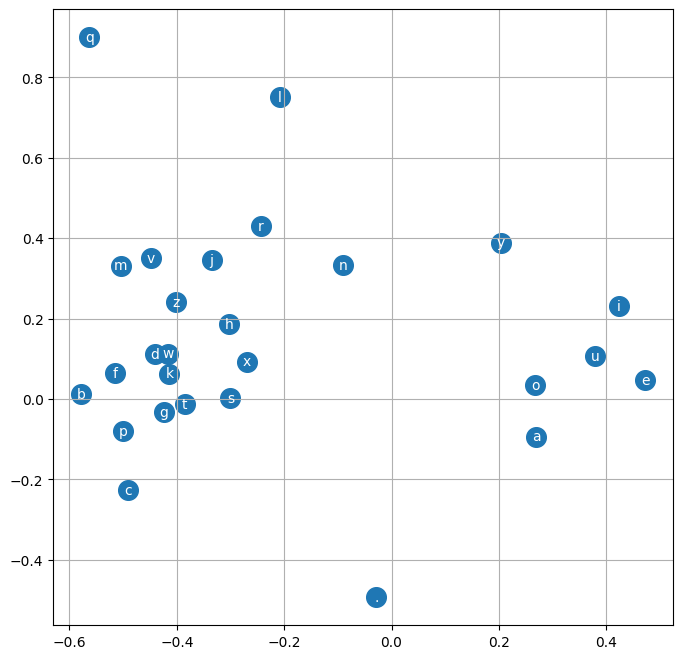

In [238]:
# If we keep the dimensions of the input vector = 2, then we can see how 
# characters clump together when plotting the features on the X,Y axis.
# For example, the vowels a, e, i, o, u, and even y are close together 
# (probably indicating they are similar), while letters like q and the
# special stop token are sort of on their own.
# NOTE: this is harder to visualize when we increase the feature size.
C1 = parameters[0]
plt.figure(figsize=(8, 8))
plt.scatter(C1[:, 0].tolist(), C1[:, 1].tolist(), s=200)
for i in range(C1.shape[0]):
    plt.text(C1[i, 0].item(), C1[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')